# Project Pitch: Initial EDA (NLP with Disaster Tweets)

This notebook produces the **initial data exploration** for our project pitch.

**How to use**
1. Create this folder structure next to the notebook:
   ```
   data/          # put train.csv and test.csv here
   reports/
     figures/     # charts will be saved here
   ```
2. Run all cells, top to bottom.
3. Import the saved figures into your PPT.

## 1) Setup & Imports

In [1]:
import re
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR    :", DATA_DIR)
print("FIG_DIR     :", FIG_DIR)

PROJECT_ROOT: /Users/taljindersingh/Documents/Personal Space/ARIZONA STATE UNIVERSITY/19. GitHub/disaster-tweets-classification
DATA_DIR    : /Users/taljindersingh/Documents/Personal Space/ARIZONA STATE UNIVERSITY/19. GitHub/disaster-tweets-classification/data
FIG_DIR     : /Users/taljindersingh/Documents/Personal Space/ARIZONA STATE UNIVERSITY/19. GitHub/disaster-tweets-classification/reports/figures


## 2) Load Data

In [2]:
train_path = DATA_DIR / "train.csv"
test_path  = DATA_DIR / "test.csv"

assert train_path.exists(), "Please place train.csv in the data/ folder."
assert test_path.exists(),  "Please place test.csv in the data/ folder."

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test  shape:", test.shape)
print("Train columns:", list(train.columns))
train.head()

Train shape: (7613, 5)
Test  shape: (3263, 4)
Train columns: ['id', 'keyword', 'location', 'text', 'target']


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 3) Basic Sanity Checks

In [3]:
expected_cols = {"id", "keyword", "location", "text", "target"}
missing = expected_cols - set(train.columns)
assert not missing, f"Missing expected column(s): {missing}"

assert set(train["target"].unique()).issubset({0,1}), "target must be binary (0/1)"
print("Sanity checks passed ✅")

Sanity checks passed ✅


## 4) Missingness

location    33.3
keyword      0.8
id           0.0
text         0.0
target       0.0
dtype: float64

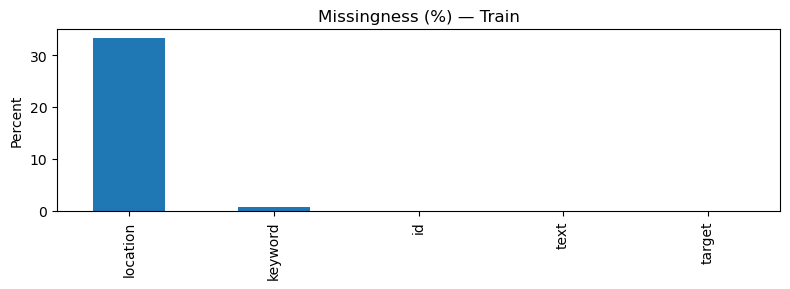

In [4]:
missing_pct = (train.isna().mean()*100).sort_values(ascending=False).round(1)
display(missing_pct)

ax = missing_pct.plot(kind="bar", figsize=(8,3))
ax.set_title("Missingness (%) — Train")
ax.set_ylabel("Percent")
plt.tight_layout()
plt.savefig(FIG_DIR / "missingness_train.png", dpi=200)
plt.show()

## 5) Class Balance

Counts:
 target
0    4342
1    3271

Percents:
 target
0    57.0
1    43.0


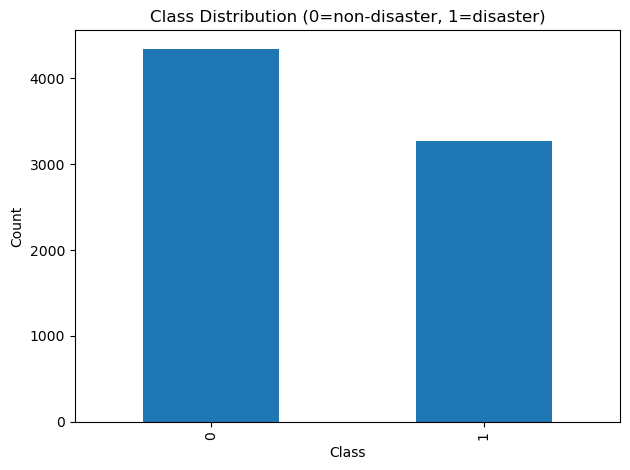

In [5]:
counts = train["target"].value_counts().sort_index()
pct = (counts / counts.sum() * 100).round(1)
print("Counts:\n", counts.to_string())
print("\nPercents:\n", pct.to_string())

ax = counts.plot(kind="bar")
ax.set_title("Class Distribution (0=non-disaster, 1=disaster)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "class_balance.png", dpi=200)
plt.show()

## 6) Tweet Length Distributions

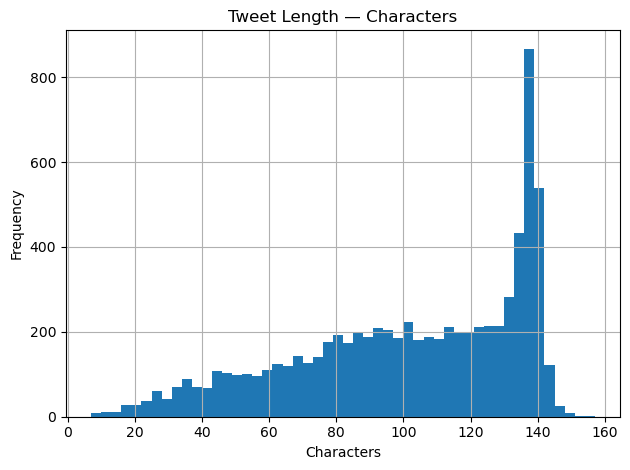

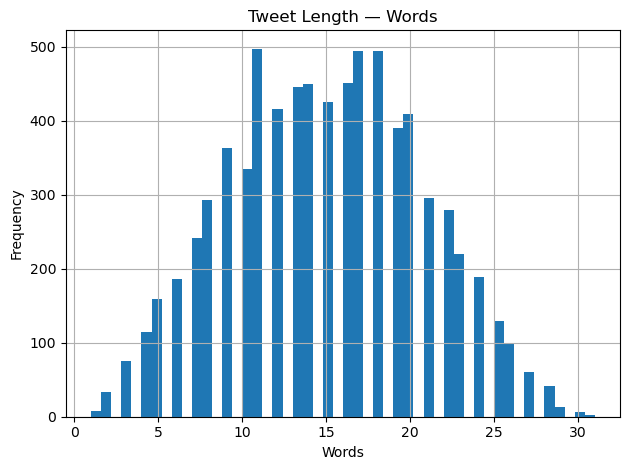

In [6]:
train["n_chars"] = train["text"].astype(str).str.len()
train["n_words"] = train["text"].astype(str).str.split().str.len()

fig1 = plt.figure()
train["n_chars"].hist(bins=50)
plt.title("Tweet Length — Characters")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.tight_layout()
fig1.savefig(FIG_DIR / "len_chars_hist.png", dpi=200)

fig2 = plt.figure()
train["n_words"].hist(bins=50)
plt.title("Tweet Length — Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
fig2.savefig(FIG_DIR / "len_words_hist.png", dpi=200)

plt.show()

## 7) Tweet Signals (URLs, @mentions, #hashtags, emoji count, UPPERCASE ratio)

,has_url,has_mention,has_hashtag,n_emojis,upper_ratio
target,,,,,
0,0.414,0.309,0.204,0.0,0.128
1,0.664,0.204,0.262,0.0,0.134


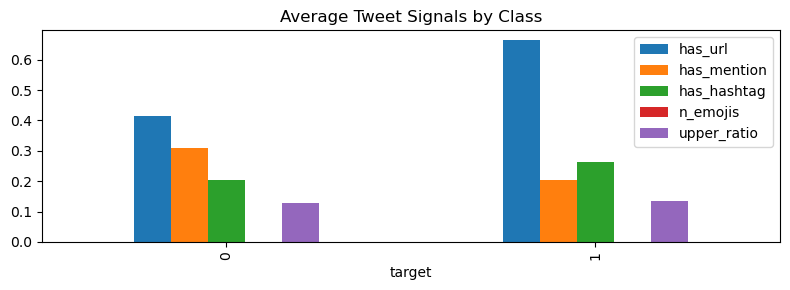

In [7]:
url_pat = re.compile(r"https?://\S+")
mention_pat = re.compile(r"@\w+")
hashtag_pat = re.compile(r"#\w+")

# Broad emoji coverage without external package
EMOJI_REGEX = re.compile(
    r"[\U0001F1E6-\U0001F1FF]|"  # flags
    r"[\U0001F300-\U0001F5FF]|"  # symbols & pictographs
    r"[\U0001F600-\U0001F64F]|"  # emoticons
    r"[\U0001F680-\U0001F6FF]|"  # transport & map
    r"[\U0001F700-\U0001F77F]|"
    r"[\U0001F780-\U0001F7FF]|"
    r"[\U0001F800-\U0001F8FF]|"
    r"[\U0001F900-\U0001F9FF]|"
    r"[\U0001FA00-\U0001FAFF]|"
    r"[\u2600-\u26FF]",
    flags=re.UNICODE
)

def has_url(s: str) -> int:
    return int(bool(url_pat.search(s)))

def has_mention(s: str) -> int:
    return int(bool(mention_pat.search(s)))

def has_hashtag(s: str) -> int:
    return int(bool(hashtag_pat.search(s)))

def count_emojis(s: str) -> int:
    return len(EMOJI_REGEX.findall(s))

def upper_ratio(s: str) -> float:
    letters = [ch for ch in s if ch.isalpha()]
    return (sum(ch.isupper() for ch in letters)/len(letters)) if letters else 0.0

for df in (train, test):
    t = df["text"].astype(str)
    df["has_url"] = t.apply(has_url)
    df["has_mention"] = t.apply(has_mention)
    df["has_hashtag"] = t.apply(has_hashtag)
    df["n_emojis"] = t.apply(count_emojis)
    df["upper_ratio"] = t.apply(upper_ratio)

signal_cols = ["has_url","has_mention","has_hashtag","n_emojis","upper_ratio"]
signal_summary = train.groupby("target")[signal_cols].mean().round(3)
display(signal_summary)

ax = signal_summary.plot(kind="bar", figsize=(8,3))
ax.set_title("Average Tweet Signals by Class")
plt.tight_layout()
plt.savefig(FIG_DIR / "signals_by_class.png", dpi=200)
plt.show()

## 8) Keyword & Location Quality

keyword missing: 0.8%
location missing: 33.3%


keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: count, dtype: int64

location
USA                105
New York            73
United States       50
London              46
Nigeria             32
Canada              30
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
California          20
Chicago, IL         19
Worldwide           19
Australia           19
New York, NY        16
Everywhere          15
California, USA     15
Los Angeles         15
Name: count, dtype: int64

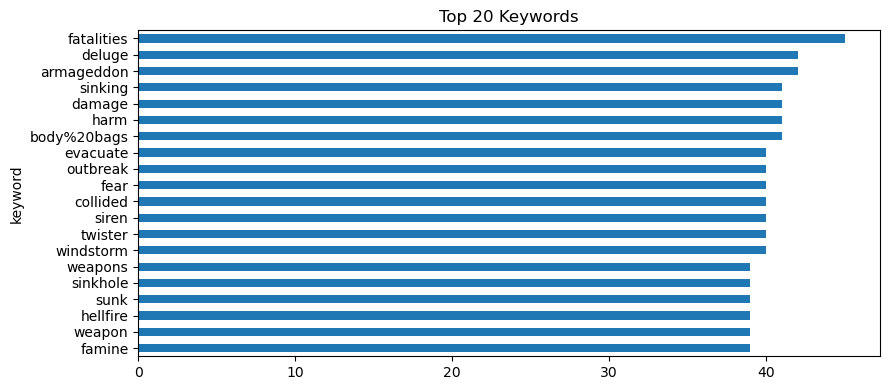

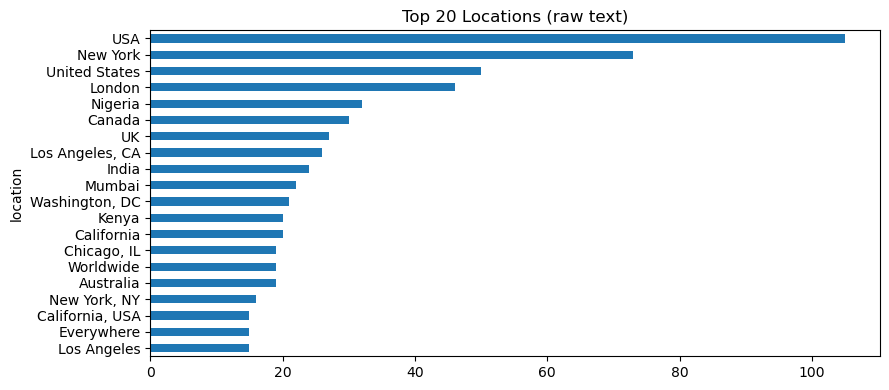

In [8]:
kw_missing = (train["keyword"].isna().mean()*100).round(1)
loc_missing = (train["location"].isna().mean()*100).round(1)
print(f"keyword missing: {kw_missing}%")
print(f"location missing: {loc_missing}%")

top_kw = train["keyword"].dropna().str.lower().value_counts().head(20)
top_loc = train["location"].dropna().str.strip().value_counts().head(20)
display(top_kw)
display(top_loc)

ax = top_kw.sort_values().plot(kind="barh", figsize=(9,4))
ax.set_title("Top 20 Keywords")
plt.tight_layout()
plt.savefig(FIG_DIR / "top_keywords.png", dpi=200)
plt.show()

ax = top_loc.sort_values().plot(kind="barh", figsize=(9,4))
ax.set_title("Top 20 Locations (raw text)")
plt.tight_layout()
plt.savefig(FIG_DIR / "top_locations.png", dpi=200)
plt.show()

## 9) Duplicates

In [9]:
dup_count = int(train["text"].duplicated().sum())
print("Exact duplicate texts in train:", dup_count)

dups = train[train["text"].duplicated(keep=False)].sort_values("text").head(10)
dups[["id","text","target"]]

Exact duplicate texts in train: 110


,id,text,target
4290,6094,#Allah describes piling up #wealth thinking it...,0
4299,6105,#Allah describes piling up #wealth thinking it...,0
4312,6123,#Allah describes piling up #wealth thinking it...,1
6363,9095,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6377,9113,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6378,9114,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6366,9098,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
2828,4064,#KCA #VoteJKT48ID 12News: UPDATE: A family of ...,1


## 10) Quick Summary Dictionary (copy into slides)

In [10]:
summary = {
    "n_train": int(train.shape[0]),
    "n_test": int(test.shape[0]),
    "class_counts": train["target"].value_counts().to_dict(),
    "class_pct": (train["target"].value_counts(normalize=True)*100).round(1).to_dict(),
    "kw_missing_pct": float(kw_missing),
    "loc_missing_pct": float(loc_missing),
    "avg_chars": float(train["n_chars"].mean()),
    "avg_words": float(train["n_words"].mean())
}
summary

{'n_train': 7613,
 'n_test': 3263,
 'class_counts': {0: 4342, 1: 3271},
 'class_pct': {0: 57.0, 1: 43.0},
 'kw_missing_pct': 0.8,
 'loc_missing_pct': 33.3,
 'avg_chars': 101.03743596479706,
 'avg_words': 14.903585971364771}